In [1]:
from glob import glob
from os import path
import numpy as np
from halotools.sim_manager import CachedHaloCatalog, RockstarHlistReader, UserSuppliedPtclCatalog
from helpers.readGadgetSnapshot import readGadgetSnapshot
from AbundanceMatching import *

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


Similar to the other catalog notebook, I'll be loading a catalog of halos then abundance matching them with a luminosity function. However, this time I'm loading a catalog that we have on disk at SLAC instead of one in the cloud. This will require one of Yao's other packages, [helpers](https://bitbucket.org/yymao/helpers/src). After it's loaded, I'll use [Yao's code](https://bitbucket.org/yymao/abundancematching) to do the abundance matching.

In [2]:
simname = 'chinchilla'
Lbox = 400
npart = 2048

In [3]:
z = 0.2
a = 1/(1+z)

In [4]:
HLIST_COLS = {'halo_id': (1, 'i8'), 'halo_upid': (6, 'i8'),
              'halo_x': (17, 'f4'), 'halo_y': (18, 'f4'), 'halo_z': (19, 'f4'),
              'halo_vx': (20, 'f4'), 'halo_vy': (21, 'f4'), 'halo_vz': (22, 'f4'),
              'halo_mvir': (10, 'f4'), 'halo_rvir': (11, 'f4'), 'halo_rs':(12, 'f4'),
              'halo_snapnum': (31, 'i8'),'halo_vpeak':(57, 'f8'), 'halo_halfmass_scale': (58, 'f4')}

In [5]:
loc = '/nfs/slac/g/ki/ki21/cosmo/yymao/sham_test/resolution-test/'
columns_to_keep = HLIST_COLS
columns_to_convert = list(set(["halo_rvir", "halo_rs"])& set( columns_to_keep.keys()) )

halo_finder = 'rockstar'

#may also work for 1050 too.
pmass = 1.44390e+08*((Lbox / 125.0) ** 3) * ((1024.0/npart)** 3)
valid_version_names = {'Lb125-1024', 'Lb125-2048', 'Lb250-1024', 'Lb250-128',
                        'Lb250-196', 'Lb250-2048', 'Lb250-2560', 'Lb250-320',
                        'Lb250-512', 'Lb250-768', 'Lb250-85', 'Lb400-1024',
                        'Lb400-136', 'Lb400-2048', 'Lb400-210', 'Lb400-315',
                        'Lb400-512', 'Lb400-768'}
#check that this combination of lbox and npart exists
version_name = 'Lb%d-%d' % (int(Lbox), npart)
assert version_name in valid_version_names
#add a subdirectory
loc += 'c%d-%d/' % (int(Lbox), int(npart))

gadget_loc = loc
loc += '/rockstar/hlists/'
gadget_loc+='/output/'

#Chinchillas also have to be cached differently.
cache_loc ='/u/ki/swmclau2/des/halocats/hlist_%.2f.list.%s_%s.hdf5'
cache_filename = cache_loc % (a, simname, version_name)  # make sure we don't have redunancies.

In [6]:
tmp_fnames = sorted(glob(loc + 'hlist_*.list'))  # snag all the hlists
available_fnames = [fname[len(loc):] for fname in tmp_fnames]  # just want the names in the dir
available_scale_factors = [float(fname[6:-5]) for fname in available_fnames]  # pull out scale factors
 
idx = np.argmin(np.abs(np.array(available_scale_factors) - a))

In [ ]:
fname = path.join(loc, available_fnames[idx])
reader = RockstarHlistReader(fname, columns_to_keep, cache_filename, simname,
                             halo_finder, z, version_name, Lbox, pmass,
                             overwrite=True)
reader.read_halocat(columns_to_convert, write_to_disk=True, update_cache_log=True)

In [7]:
all_snapdirs = glob(path.join(gadget_loc, 'snapdir*'))
snapdir = all_snapdirs[idx]#only the snapdir for the scale factor were interested in .

In [ ]:
np.random.seed(56789)
p = 1e-5
all_particles = np.array([], dtype='float32')
# TODO should fail gracefully if memory is exceeded or if p is too small.
for file in glob(path.join(snapdir, 'snapshot*')):
    #print file
    # TODO should find out which is "fast" axis and use that.
    # Numpy uses fortran ordering.
    particles = readGadgetSnapshot(file, read_pos=True)[1]  # Think this returns some type of tuple; should check
    downsample_idxs = np.random.choice(particles.shape[0], size =int( particles.shape[0]*p))
    particles = particles[downsample_idxs, :]
    #particles = particles[np.random.rand(particles.shape[0]) < p]  # downsample
    if particles.shape[0] == 0:
        continue

    all_particles = np.resize(all_particles, (all_particles.shape[0] + particles.shape[0], 3))
    all_particles[-particles.shape[0]:, :] = particles

In [ ]:
ptcl_catalog = UserSuppliedPtclCatalog(redshift=z, Lbox=Lbox, particle_mass=pmass,\
                                       x=all_particles[:,0], y=all_particles[:,1], z=all_particles[:,2])
ptcl_cache_loc ='/u/ki/swmclau2/des/halocats/ptcl_%.2f.list.%s_%s.hdf5'
ptcl_cache_filename = ptcl_cache_loc % (a, simname, version_name)  # make sure we don't have redunancies.
ptcl_catalog.add_ptclcat_to_cache(ptcl_cache_filename, simname, version_name, 'p=%f'%p)

Now we've cached the halo catalog and the particles. You'll probably want to turn off the above cells (the two directly above this one and the one four above) as they only have to be run once. Now let's do the matching. 

In [8]:
halocat = CachedHaloCatalog(simname = simname,halo_finder= halo_finder, redshift = z, version_name=version_name,dz_tol = 0.01)

In [9]:
halocat.halo_table.colnames

['halo_upid',
 'halo_y',
 'halo_x',
 'halo_z',
 'halo_rvir',
 'halo_vpeak',
 'halo_snapnum',
 'halo_halfmass_scale',
 'halo_id',
 'halo_vx',
 'halo_vy',
 'halo_vz',
 'halo_rs',
 'halo_mvir',
 'halo_nfw_conc',
 'halo_hostid',
 'halo_mvir_host_halo']

Loading up a luminosity function. This one is from GAMA Survey, Loveday 2015 (got it from Joe). It is tweaked from the one from the other notebook to reflect the new redshfit range.

In [10]:
lf = np.genfromtxt('lf_r_sersic_z_0.2_0.3.dat', skip_header=True)[:,1:3]
#lf = np.genfromtxt('lf_r_sersic_z_0.1_0.2.dat', skip_header=True)[:,1:3]

In [11]:
lf

array([[ -2.38800000e+01,   3.93000000e-07],
       [ -2.33800000e+01,   1.87000000e-06],
       [ -2.31200000e+01,   7.22000000e-06],
       [ -2.28800000e+01,   1.87000000e-05],
       [ -2.26200000e+01,   4.10000000e-05],
       [ -2.23800000e+01,   1.09000000e-04],
       [ -2.21200000e+01,   2.16000000e-04],
       [ -2.18800000e+01,   3.88000000e-04],
       [ -2.16200000e+01,   7.28000000e-04],
       [ -2.13800000e+01,   1.17000000e-03],
       [ -2.11200000e+01,   1.80000000e-03],
       [ -2.08800000e+01,   2.52000000e-03],
       [ -2.06200000e+01,   3.33000000e-03],
       [ -2.03800000e+01,   4.20000000e-03],
       [ -2.01200000e+01,   4.87000000e-03],
       [ -1.98800000e+01,   6.02000000e-03],
       [ -1.96200000e+01,   6.58000000e-03],
       [ -1.93800000e+01,   5.65000000e-03],
       [ -1.91200000e+01,   1.03000000e-03],
       [ -1.88800000e+01,   7.84000000e-05],
       [ -1.86200000e+01,   4.93000000e-04],
       [ -1.83800000e+01,   2.24000000e-04],
       [ -

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

In [13]:
use_up_to = -6
af = AbundanceFunction(lf[:use_up_to,0], lf[:use_up_to,1], (-27, -18),faint_end_fit_points = 7 )

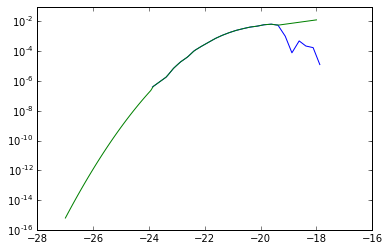

In [14]:
plt.semilogy(lf[:,0], lf[:,1])
x = np.linspace(-27, -18, 101)
plt.semilogy(x, af(x))

In [15]:
print max(af(x))

0.0128038958073


In [16]:
scatter = 0.2
remainder = af.deconvolute(scatter*LF_SCATTER_MULT, 20)

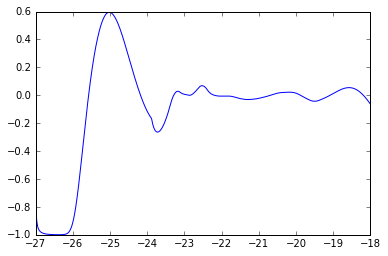

In [17]:
x, nd = af.get_number_density_table()
plt.plot(x, remainder/nd);

In [18]:
max(nd)

0.020700864149967049

In [19]:
halos = np.array(halocat.halo_table)
    
nd_halos = calc_number_densities(halos['halo_vpeak'], halocat.Lbox[0])

In [20]:
full_catalog = af.match(nd_halos, scatter*LF_SCATTER_MULT)

In [21]:
mag_cut = -18 
valid_idxs = np.logical_and(~np.isnan(full_catalog), full_catalog <= mag_cut)
catalog = full_catalog[valid_idxs]

/afs/slac.stanford.edu/u/ki/swmclau2/.local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app


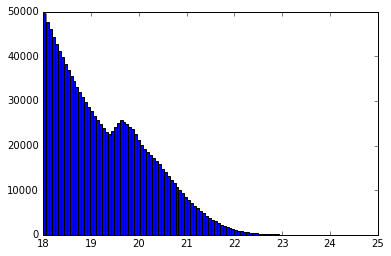

In [22]:
plt.hist(-1*catalog, bins = 30);

We want this plot to approximately match this one from Song. 

In [23]:
song_cat = np.genfromtxt('gama_z0.1_0.3_rband_absmag.ascii')

In [24]:
mags = song_cat[song_cat[:,-1] > -10000,-1 ]

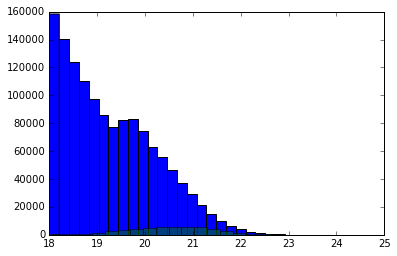

In [25]:
#plt.hist(-1*catalog, bins = 30)
plt.hist(-1*mags, bins = 30);
plt.xlim([18,25]);

In [26]:
#downsample here
hist, bin_edges = np.histogram(-1*mags, bins = 30)
downsample_idxs = set()
makeshift_hist = []
for idx, count in enumerate(hist):
    low, high = bin_edges[idx:idx+2]
    in_bin_idxs = np.where(np.logical_and(low <= -1*catalog, -1*catalog <= high))[0]
    if in_bin_idxs.shape[0] <= count:
        sampled_idxs = in_bin_idxs
    else:
        sampled_idxs = np.random.choice(in_bin_idxs, size = count, replace = False)

    downsample_idxs = downsample_idxs | set(sampled_idxs)
    
downsampled_catalog = catalog[np.array(list(downsample_idxs), dtype=int)]

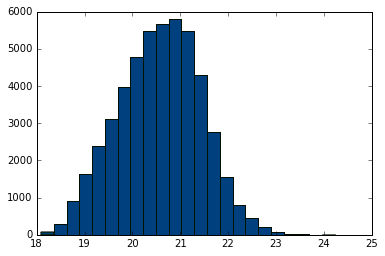

In [27]:
plt.hist(-1*downsampled_catalog, bins = bin_edges)
plt.hist(-1*mags, bins = bin_edges, alpha = 0.5);
plt.xlim([18,25]);

Yeah! let's save the indexs. 

In [46]:
downsampled_idxs_array = np.zeros_like(valid_idxs, dtype=bool)
counter = 0
for idx, val in enumerate(valid_idxs):
    if val:
        if counter in downsample_idxs:
            downsampled_idxs_array[idx] = True
        counter+=1


In [52]:
downsampled_idxs_array= np.where(valid_idxs)[0][np.array(list(downsample_idxs))]

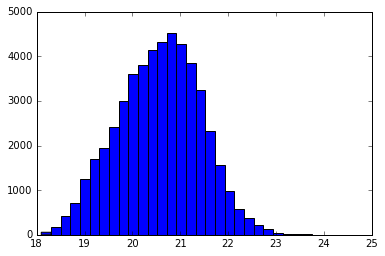

In [53]:
plt.hist(-1*full_catalog[downsampled_idxs_array], bins = 30);

In [54]:
np.savetxt('gama_matched_catalog.npy', full_catalog)
np.savetxt('gama_matched_catalog_idxs.npy', downsampled_idxs_array)